In [1]:
import matplotlib.pyplot as plt
import numpy as np
from common.trajectory_analysis import Trajectory

In [2]:
from scipy import signal

def butterworth(x, cutoff, samples_per_s=200, filter_order=2):
    B, A = signal.butter(filter_order, cutoff / (samples_per_s / 2), 'low')
    return signal.filtfilt(B, A, x, method="gust")

In [3]:
import json, glob

files = glob.glob("..//data1//*.txt")

lowpass_cutoff = 10 # Hz
dt             = 0.005   # s
pxtomm         = 1/10.8  # from tablet px to mm

A = np.array
data = []
for f in files:
    d = json.load(open(f))
    d["filename"] = f
    ts = [d["ts"][i] - d["ts"][0] for i in range(len(d["ts"]))]
    tx = A(d["tx"]) * pxtomm
    ty = A(d["ty"]) * pxtomm
    cx = A(d["cx"]) * pxtomm
    cy = A(d["cy"]) * pxtomm
    
    d["target"] = Trajectory(tx, ty, ts, dt=dt, cut = [4, 0.2])
    d["target"].calc_betas(orthogonal=True)
        
    d["cursor"] = Trajectory(cx, cy, ts, dt=dt, cut = [4, 0.2], smooth=lowpass_cutoff)
    d["cursor"].calc_betas(orthogonal=False)
    
    data.append(d)


In [4]:
filename_speeds = [     3,    5,    7,    9,   11,   13,   15,   17,   19]
freqs           = [  0.27, 0.40, 0.54, 0.67, 0.81, 0.94, 1.07, 1.21, 1.34]  # Hz

for d in data:
    f = d["filename"]
    spi = f.find("speed")
    fn_speed = int(f[spi+5:spi+8])
    fri = filename_speeds.index(fn_speed)
    d["freq"] = freqs[fri]
    


In [5]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 16}
matplotlib.rc('font', **font)

0.27


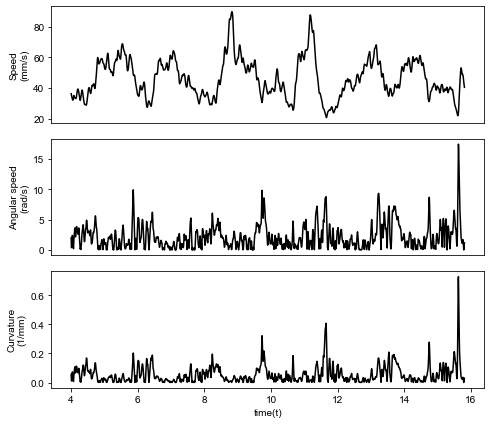

In [6]:
d = data[71]
print(d["freq"])
c = d["cursor"]
t = d["target"]

plt.figure(figsize=[7, 6])
plt.subplot(311)
plt.plot(c.t, c.V, "k")
plt.ylabel("Speed" "\n" "(mm/s)")
plt.xticks([])
plt.subplot(312)
plt.plot(c.t, c.A, "k")
plt.ylabel(r"Angular speed" "\n" "(rad/s)")
plt.xticks([])
plt.subplot(313)
plt.plot(c.t, c.C, "k")
plt.ylabel(r"Curvature" "\n" "(1/mm)")
plt.xlabel("time(t)")
plt.tight_layout()
plt.show()

In [7]:
colors = {
    "target": "#882255",
    "cursor": "#44AA99"
}

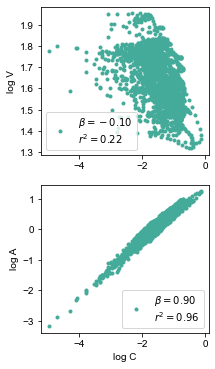

In [8]:

plt.figure(figsize=[3, 6])

plt.title("VC power law")    
plt.subplot(211)
plt.plot(c.logC, c.logV, '.', color=colors["cursor"], label=fr"$\beta = {c.betaCV:.2f}$" "\n"  fr"$r^2 = {c.r2CV:.2f}$" )    
plt.legend(loc="lower left", prop={'size':10})
plt.ylabel("log V")
plt.subplot(212)
plt.plot(c.logC, c.logA, '.', color=colors["cursor"], label=fr"$\beta = {c.betaCA:.2f}$" "\n"  fr"$r^2 = {c.r2CA:.2f}$" )
plt.xlabel("log C")
plt.ylabel("log A")

plt.legend(loc="lower right", prop={'size':10})
plt.show()

In [9]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 15}

matplotlib.rc('font', **font)

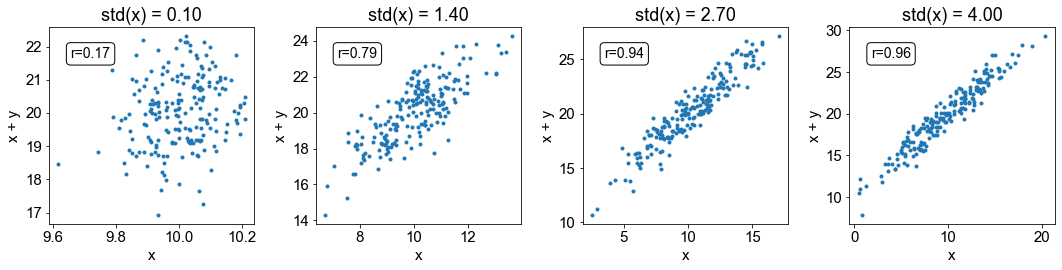

In [10]:
N = 200

y = np.random.normal(size=N, loc = 10, scale = 1)
scale = np.linspace(0.1, 4, 4)
plt.figure(figsize=[15, 4])

for idx, s in enumerate(scale):
    x = np.random.normal(size=N, loc = 10, scale = s)
    plt.subplot(1, 4, idx + 1)
    r = np.corrcoef(x, x + y)[0,1]
    
    plt.title(f"std(x) = {s:.2f}")
    #plt.xticks([])
    #plt.yticks([])
    plt.plot(x, x+y, '.')
    s=f"r={r:.2f}"
    plt.annotate(s, xy =(0.3, 0.9), xycoords='axes fraction',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))

    plt.xlabel(fr"x")
    plt.ylabel(fr"x + y")
    

    
plt.tight_layout()
#plt.savefig("..//figures//correlation sums.png", format="png", bbox_inches="tight", dpi=600)
plt.show()    

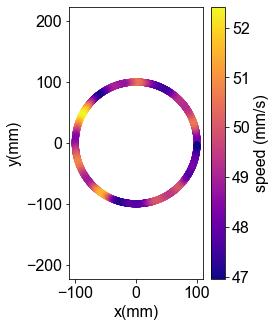

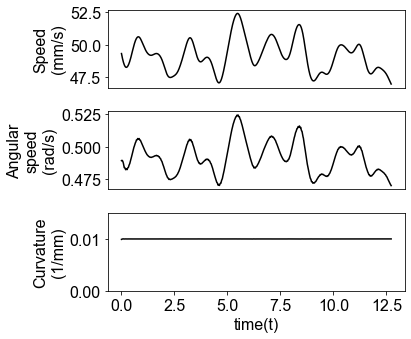

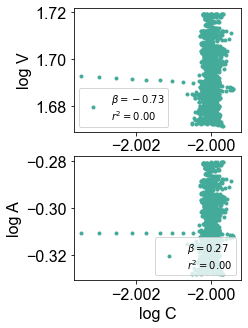

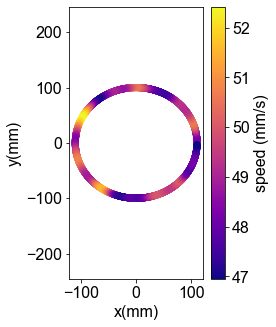

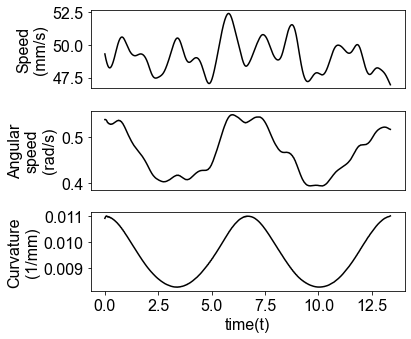

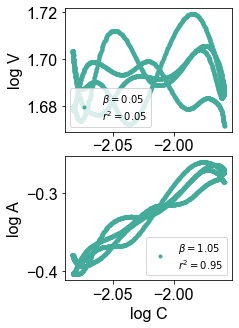

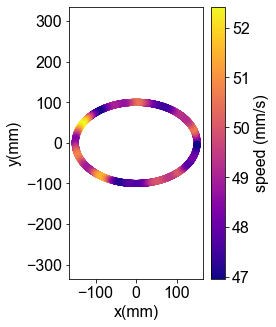

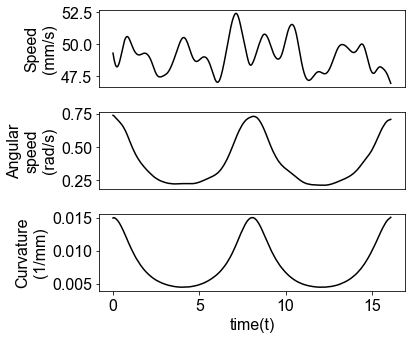

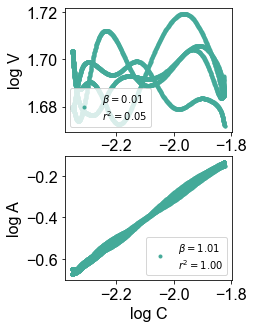

In [293]:
np.random.seed(152)


def butterworth(x, cutoff, samples_per_s=200, filter_order=2):
    B, A = signal.butter(filter_order, cutoff / (samples_per_s / 2), 'low')
    return signal.filtfilt(B, A, x, method="pad", padlen=5)


dt = 0.005
t0 = np.arange(0, 1, dt)
ys = 100 * np.sin(t0*2*np.pi*1)
v0 = np.random.normal(loc=50, scale=5, size=t0.size)
v1 = butterworth(v0, 10)
def distance(x0, y0, x1, y1):  return ((x0-x1)**2 + (y0-y1)**2)**0.5

for b in [100, 110, 150]:
    xs = b * np.cos(t0*2*np.pi*1) 
    dts = np.zeros(t0.size)
    distances = [ distance(xs[i], ys[i], xs[i-1], ys[i-1]) for i in range(len(xs)) ]
    for i in range(1, t0.size):  dts[i] = distances[i] / v1[i]
    t = np.cumsum(dts)
    tr = Trajectory(xs, ys, t, dt=0.005).calc_betas()
    
    plt.figure(figsize=[3,5])
    im = plt.scatter(tr.x, tr.y, c=tr.V, cmap="plasma")
    plt.axis("equal")
    plt.colorbar(im, label="speed (mm/s)")
    plt.xlabel("x(mm)")
    plt.ylabel("y(mm)")
    plt.show()

    c=tr
    plt.figure(figsize=[6, 5])
    plt.subplot(311)
    plt.plot(c.t, c.V, "k")
    plt.ylabel("Speed" "\n" "(mm/s)")
    plt.xticks([])
    plt.subplot(312)
    plt.plot(c.t, c.A, "k")
    plt.ylabel(r"Angular" "\n" "speed" "\n" "(rad/s)")
    plt.xticks([])
    plt.subplot(313)
    plt.plot(c.t, c.C, "k")
    if np.std(c.C) < 0.0001:
        plt.ylim(0, 0.015)
    plt.ylabel(r"Curvature" "\n" "(1/mm)")
    plt.xlabel("time(t)")
    plt.tight_layout()
    plt.show()
    

    plt.figure(figsize=[3, 5])    
    plt.subplot(211)
    plt.plot(c.logC, c.logV, '.', color=colors["cursor"], label=fr"$\beta = {c.betaCV:.2f}$" "\n"  fr"$r^2 = {c.r2CV:.2f}$" )    
    plt.legend(loc="lower left", prop={'size':10})
    plt.ylabel("log V")
    plt.subplot(212)
    plt.plot(c.logC, c.logA, '.', color=colors["cursor"], label=fr"$\beta = {c.betaCA:.2f}$" "\n"  fr"$r^2 = {c.r2CA:.2f}$" )
    plt.xlabel("log C")
    plt.ylabel("log A")

    plt.legend(loc="lower right", prop={'size':10})
    plt.show()

0.8652866030126134


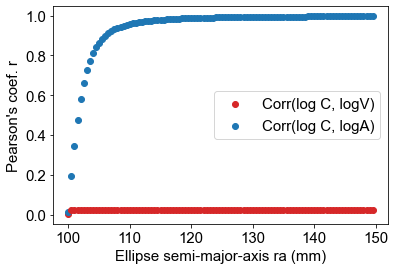

In [22]:
np.random.seed(152)

import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 15}

matplotlib.rc('font', **font)
dt = 0.005
t0 = np.arange(0, 10, dt)
ys = 100 * np.sin(t0*2*np.pi*1)
v0 = np.random.normal(loc=50, scale=5, size=t0.size)
v1 = butterworth(v0, 10)

def distance(x0, y0, x1, y1):  return ((x0-x1)**2 + (y0-y1)**2)**0.5

for b in np.arange(100, 150, 0.5):
    xs = b * np.cos(t0*2*np.pi*1) 
    dts = np.zeros(t0.size)
    distances = [ distance(xs[i], ys[i], xs[i-1], ys[i-1]) for i in range(len(xs)) ]
    for i in range(1, t0.size):  dts[i] = distances[i] / v1[i]
    t = np.cumsum(dts)
    tr = Trajectory(xs, ys, t, dt=0.005).calc_betas()
    plt.scatter(b, np.sqrt(tr.r2CV), color="tab:red")
    plt.scatter(b, np.sqrt(tr.r2CA), color="tab:blue")
    if b==105: print(np.sqrt(tr.r2CA))

plt.scatter([],[], color="tab:red", label="Corr(log C, logV)")
plt.scatter([],[], color="tab:blue", label="Corr(log C, logA)")
plt.legend()
plt.xlabel("Ellipse semi-major-axis ra (mm)")
plt.ylabel("Pearson's coef. r")
plt.show()

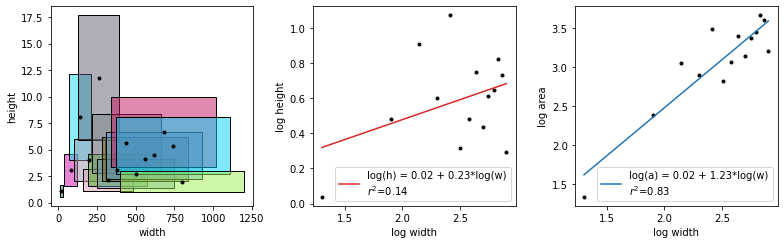

In [217]:
from matplotlib import patches

np.random.seed(176)



w = np.linspace(20, 800, 14)

hn = np.abs(np.random.normal(loc=1.0, scale=0.5, size=w.size))
h = w **(1/3) *hn

plt.figure(figsize=[11, 3.5])

plt.subplot(1,3,1)
for a, b in zip(w, h):
    col = np.random.uniform(low=0.0, high=1.0, size=3)
    r = patches.Rectangle((a-a/2,b-b/2), a, b, linewidth=1, edgecolor="black", fc=(*col,0.5))
    plt.gca().add_patch(r)

plt.plot(w,h, '.', color="black")
plt.xlabel("width")
plt.ylabel("height")

a = w * h

lw = np.log10(w)
lh = np.log10(h)
la = np.log10(a)

res = stats.linregress(lw, lh)

plt.subplot(1,3,2)
plt.plot(lw, lh, '.', color="black" )
plt.plot(lw, res.intercept + (lw*res.slope), '-', color="tab:red", label=f"log(h) = {res.intercept:.2f} + {res.slope:.2f}*log(w)\n" + fr"$r^2$={res.rvalue**2:.2f}" )
plt.legend()
plt.ylabel("log height")
plt.xlabel("log width")


res = stats.linregress(lw, la)

plt.subplot(1,3,3)
plt.plot(lw, la, '.', color="black" )
plt.plot(lw, res.intercept + (lw*res.slope), '-', color="tab:blue", label=f"log(a) = {res.intercept:.2f} + {res.slope:.2f}*log(w)\n" + fr"$r^2$={res.rvalue**2:.2f}" )
plt.legend()
plt.ylabel("log area")
plt.xlabel("log width")
plt.tight_layout()

#plt.savefig("../figures/rectangles.pdf", format="pdf", bbox_inches="tight")
plt.show()
